## Load Library

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from wordcloud import WordCloud
from nltk import ngrams

nltk.download("stopwords")
stop = set(stopwords.words("english"))

d:\ProgramData\library\environments\text_mining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Dataset Parquet

In [2]:
root = "dataset"

cnn = load_dataset(
    "parquet",
    data_files={
        "train":      f"../{root}/cnn/train/*.parquet",
        "validation": f"../{root}/cnn/validation/*.parquet",
        "test":       f"../{root}/cnn/test/*.parquet",
    }
)

train_dataset = cnn["train"]
val_dataset   = cnn["validation"]
test_dataset  = cnn["test"]

train_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 95705
})

In [3]:
df_train = train_dataset.to_pandas()
df_val   = val_dataset.to_pandas()
df_test  = test_dataset.to_pandas()

df_train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


## Check Dataset Structure

In [4]:
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

df_train.info()

Train: (95705, 3)
Validation: (13368, 3)
Test: (11490, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95705 entries, 0 to 95704
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     95705 non-null  object
 1   highlights  95705 non-null  object
 2   id          95705 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [5]:
df_train.isnull().sum()

article       0
highlights    0
id            0
dtype: int64

## Exploratory and Visualization

In [6]:
df_train["article_len"] = df_train["article"].str.split().apply(len)
df_train["summary_len"] = df_train["highlights"].str.split().apply(len)

df_train[["article_len", "summary_len"]].describe()

,article_len,summary_len
count,95705.000000,95705.000000
mean,663.641586,44.848409
std,341.722506,10.829776
min,18.000000,6.000000
25%,393.000000,38.000000
50%,614.000000,45.000000
75%,877.000000,53.000000
max,1929.000000,190.000000


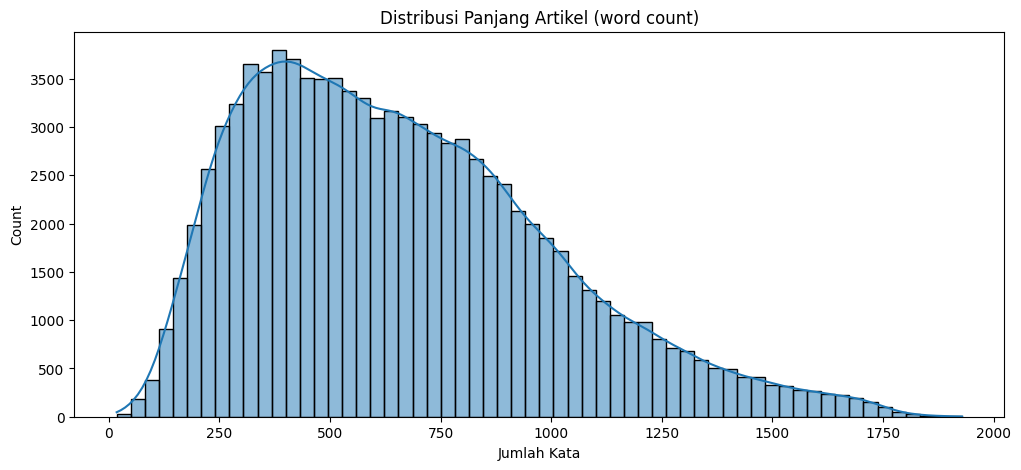

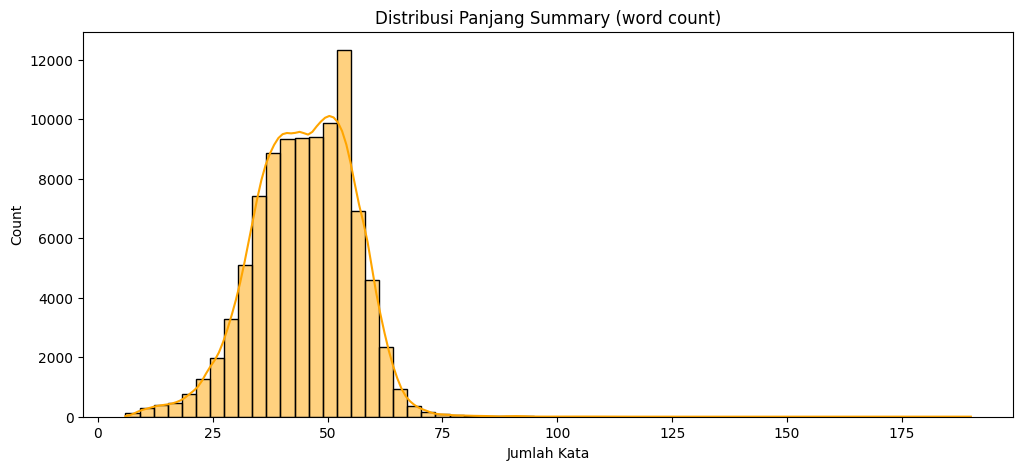

In [7]:
plt.figure(figsize=(12,5))
sns.histplot(df_train["article_len"], bins=60, kde=True)
plt.title("Distribusi Panjang Artikel (word count)")
plt.xlabel("Jumlah Kata")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_train["summary_len"], bins=60, kde=True, color="orange")
plt.title("Distribusi Panjang Summary (word count)")
plt.xlabel("Jumlah Kata")
plt.show()

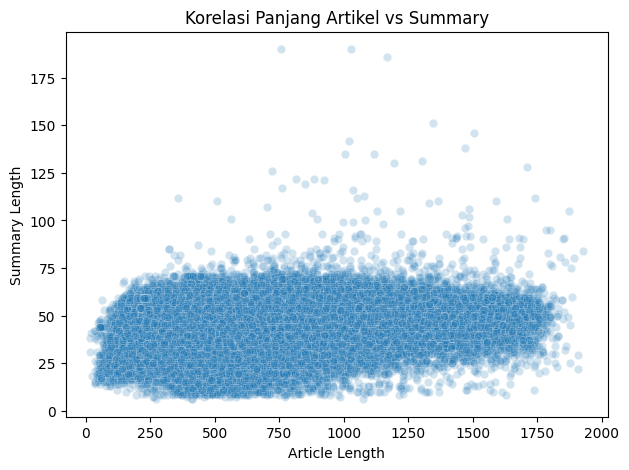

,article_len,summary_len
article_len,1.000000,0.246114
summary_len,0.246114,1.000000


In [8]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df_train["article_len"], y=df_train["summary_len"], alpha=0.2)
plt.title("Korelasi Panjang Artikel vs Summary")
plt.xlabel("Article Length")
plt.ylabel("Summary Length")
plt.show()

df_train[["article_len", "summary_len"]].corr()

In [9]:
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"[a-zA-Z]+", text)
    tokens = [t for t in tokens if t not in stop and len(t) > 2]
    return tokens

all_words = []
for text in df_train["article"].sample(500):  # ambil sampel 500
    all_words.extend(tokenize(text))

word_freq = Counter(all_words).most_common(30)
word_freq

[('said', 2925),
 ('cnn', 977),
 ('one', 908),
 ('people', 876),
 ('would', 655),
 ('year', 623),
 ('also', 588),
 ('time', 566),
 ('new', 564),
 ('two', 522),
 ('told', 486),
 ('president', 479),
 ('years', 479),
 ('like', 466),
 ('first', 461),
 ('last', 440),
 ('world', 425),
 ('many', 398),
 ('government', 380),
 ('says', 369),
 ('could', 366),
 ('police', 354),
 ('according', 340),
 ('three', 339),
 ('back', 331),
 ('family', 325),
 ('country', 324),
 ('get', 315),
 ('think', 315),
 ('day', 311)]

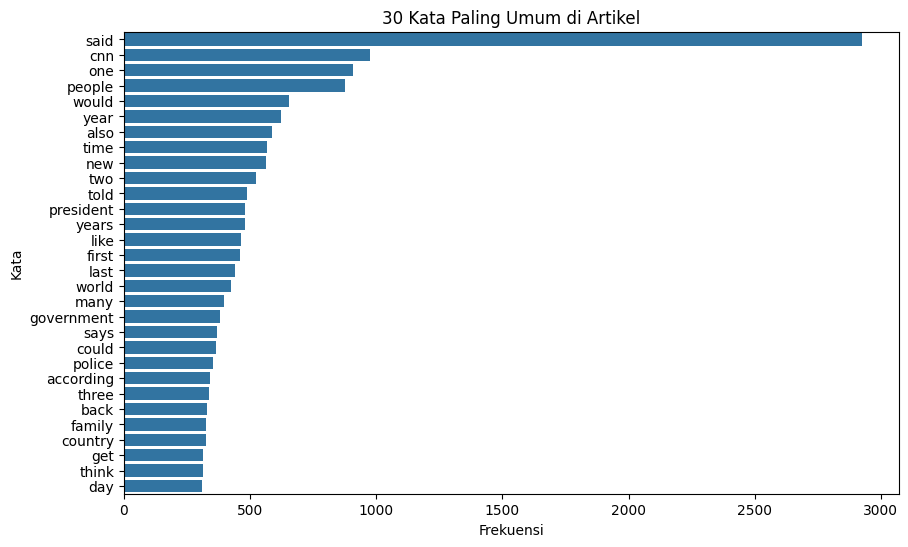

In [10]:
words, counts = zip(*word_freq)

plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words))
plt.title("30 Kata Paling Umum di Artikel")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

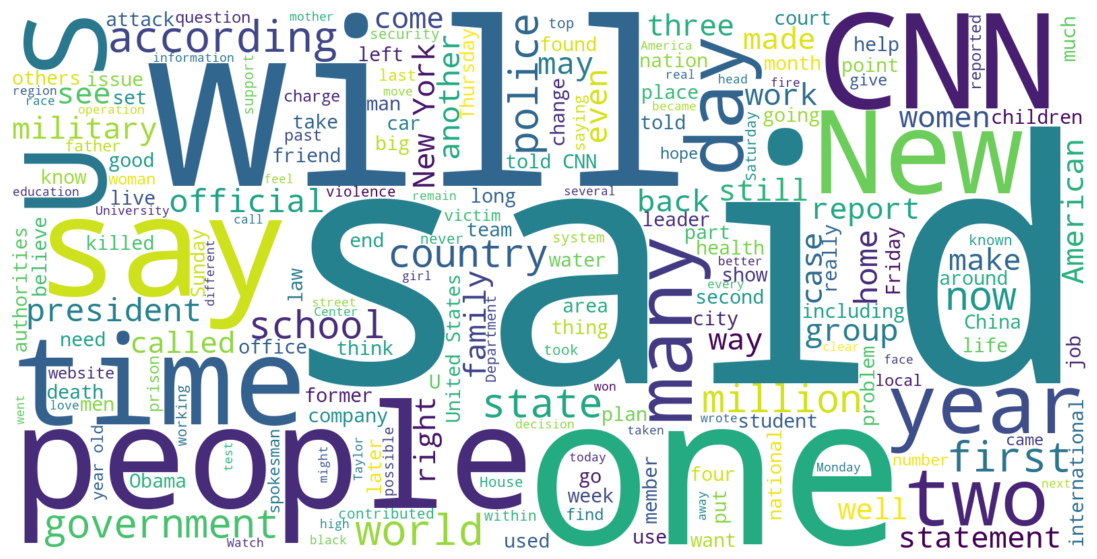

In [11]:
text = " ".join(df_train["article"].sample(200))

wc = WordCloud(width=1600, height=800, background_color="white").generate(text)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

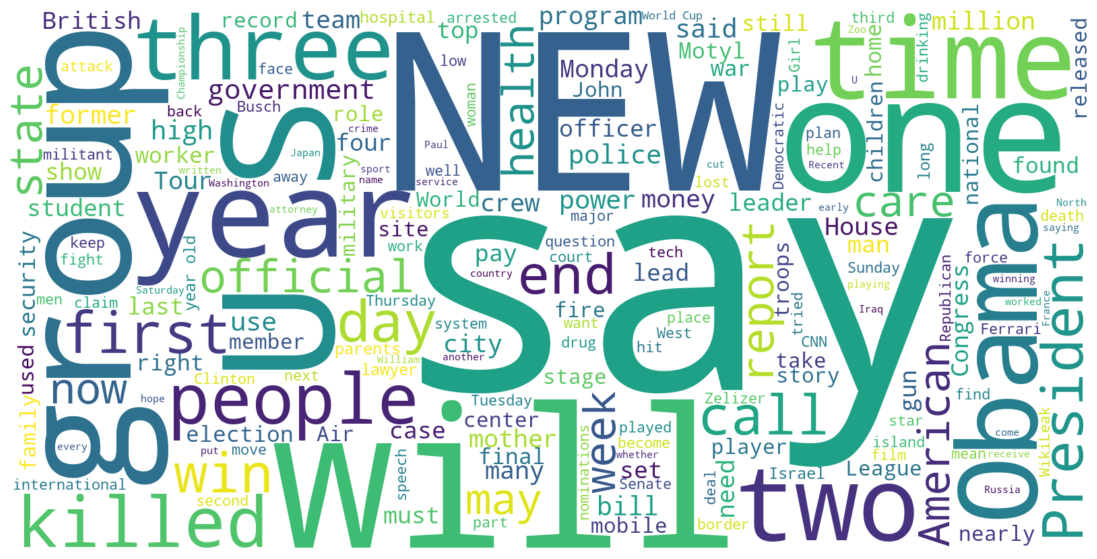

In [12]:
text = " ".join(df_train["highlights"].sample(200))

wc = WordCloud(width=1600, height=800, background_color="white").generate(text)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
def get_ngrams(corpus, n=2, top_k=20):
    all_tokens = []
    for text in corpus:
        all_tokens.extend(tokenize(text))
    ngram_freq = Counter(ngrams(all_tokens, n)).most_common(top_k)
    return ngram_freq

bigrams = get_ngrams(df_train["article"].sample(300), n=2)
trigrams = get_ngrams(df_train["article"].sample(300), n=3)

bigrams[:10], trigrams[:10]

([(('united', 'states'), 141),
  (('year', 'old'), 122),
  (('new', 'york'), 106),
  (('told', 'cnn'), 91),
  (('contributed', 'report'), 69),
  (('white', 'house'), 57),
  (('last', 'week'), 55),
  (('last', 'year'), 51),
  (('prime', 'minister'), 47),
  (('report', 'cnn'), 44)],
 [(('contributed', 'report', 'cnn'), 33),
  (('president', 'barack', 'obama'), 23),
  (('cnn', 'student', 'news'), 14),
  (('osama', 'bin', 'laden'), 12),
  (('two', 'years', 'ago'), 11),
  (('top', 'cnn', 'heroes'), 10),
  (('payroll', 'tax', 'cut'), 10),
  (('year', 'old', 'girl'), 9),
  (('opinions', 'expressed', 'commentary'), 8),
  (('expressed', 'commentary', 'solely'), 8)])

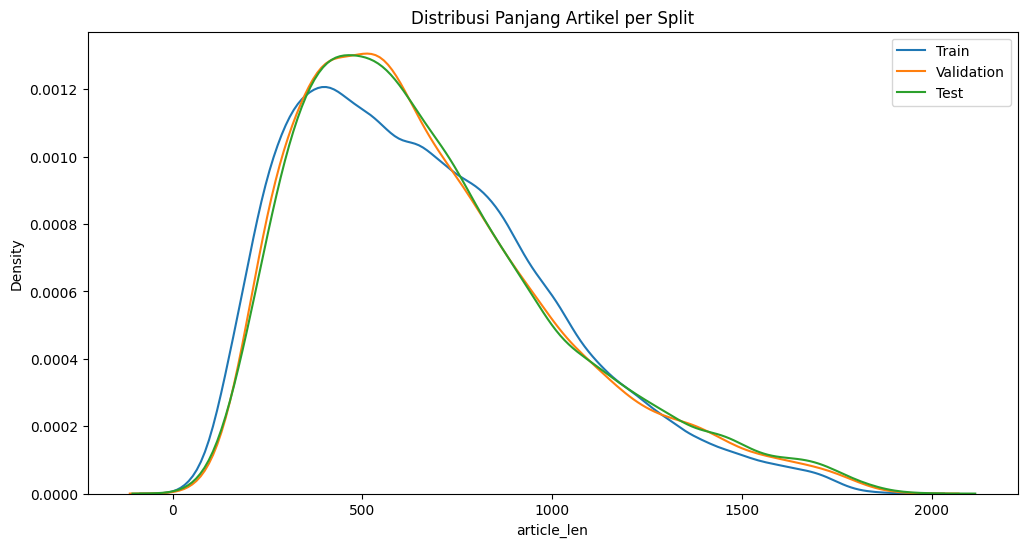

In [14]:
df_val["article_len"] = df_val["article"].str.split().apply(len)
df_test["article_len"] = df_test["article"].str.split().apply(len)

plt.figure(figsize=(12,6))
sns.kdeplot(df_train["article_len"], label="Train")
sns.kdeplot(df_val["article_len"], label="Validation")
sns.kdeplot(df_test["article_len"], label="Test")
plt.title("Distribusi Panjang Artikel per Split")
plt.legend()
plt.show()

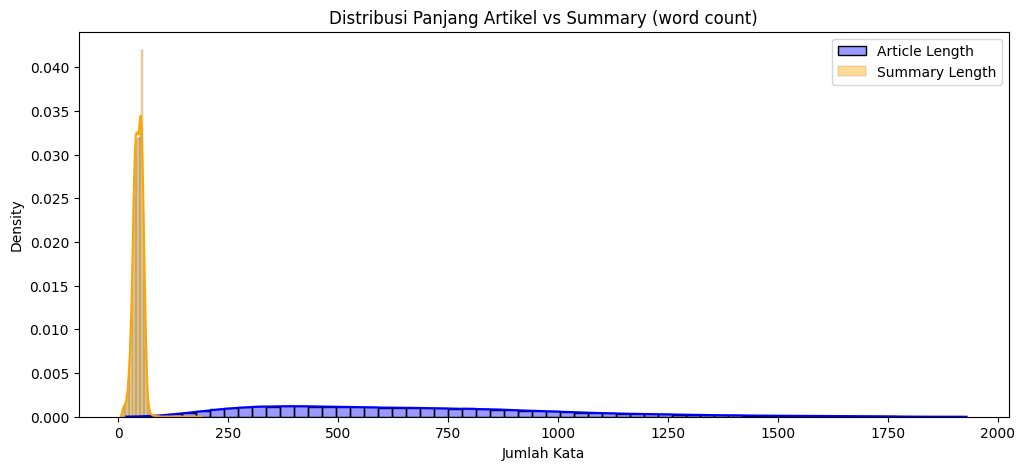

In [15]:
plt.figure(figsize=(12,5))

sns.histplot(df_train["article_len"], 
             bins=60, kde=True, color="blue", 
             label="Article Length", stat="density", alpha=0.4)

sns.histplot(df_train["summary_len"], 
             bins=60, kde=True, color="orange", 
             label="Summary Length", stat="density", alpha=0.4)

plt.title("Distribusi Panjang Artikel vs Summary (word count)")
plt.xlabel("Jumlah Kata")
plt.legend()
plt.show()